In [107]:
import warnings

warnings.filterwarnings("ignore")

# Until now:
* we talked about:
    * transformers
    * pipeline
    * tuning of pipelines
* next, we take a look on future pipeline feature, which is currently under development

# Non-sequential pipelining

## Forecast Scenario
* Electricity price forecast as a motivation use-case
* In the simplest scenario:
    * We use only historic data for forecasting


## Sequential Pipelines

* We can do this using a sequential pipeline.
* For electricity load forecasting a very simple pipeline may look as follows

<img src="../images/sequential-pipeline.png" alt="Sequential Pipelien" width="1000"/>


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

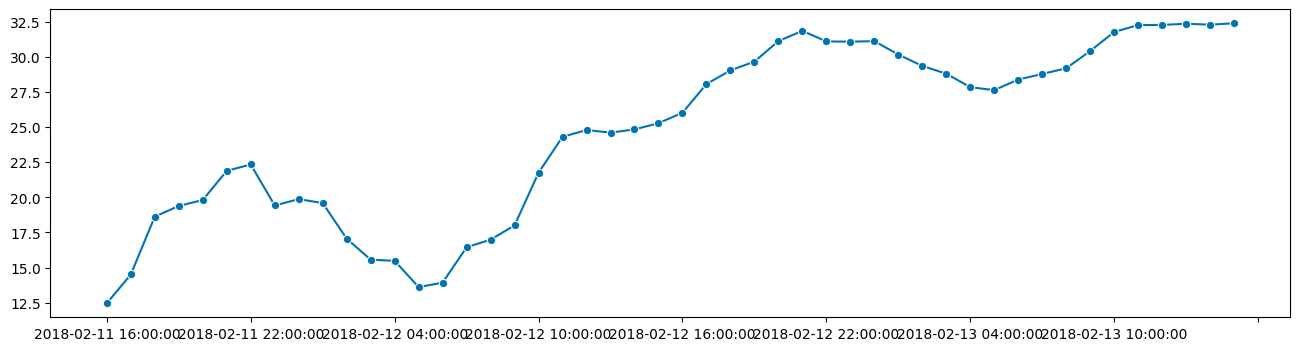

In [108]:
import pandas as pd
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA
from sklearn.preprocessing import StandardScaler
from sktime.utils.plotting import plot_series


# Load data
data = pd.read_csv("../data/getting_started_data.csv", parse_dates=["time"], index_col="time",)
data.index.freq = "H"
y = data["price"]
y_load = data["load_power_statistics"]
y_train = y.iloc[:1000]
y_train_load = y_load.iloc[:1000]
test_time = y.iloc[1000:1048].index
y_test_load = y_load.iloc[1000:1048]

# Build a simple pipeline
pipe = ForecastingPipeline(steps=[
    ("standardscaler", TabularToSeriesAdaptor(StandardScaler())),
    ("forecaster", ARIMA(order=(24, 0, 0))),
])
# Train the pipeline
pipe.fit(y_train,)

# Predict one Step
fh = ForecastingHorizon(test_time, is_relative=False)
y_pred = pipe.predict(fh=fh)
plot_series(y_pred)



### However
* additional benefical features for electrical demand forecasting exists
    * calendar features, which need to be extracted or
    * future electrical demand
* Requires
    * an additional pipeline for load forecasting, and
    * sticking the output of the load forecasting pipeline into the price forecasting pipeline

#### Load Forecast Pipeline
<img src="../images/LoadForecast.png" alt="Load Forecast" width="1000"/>

#### Price Forecast Pipeline
<img src="../images/PriceForecastAdvanced.png" alt="Price Forecast" width="1000"/>



(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

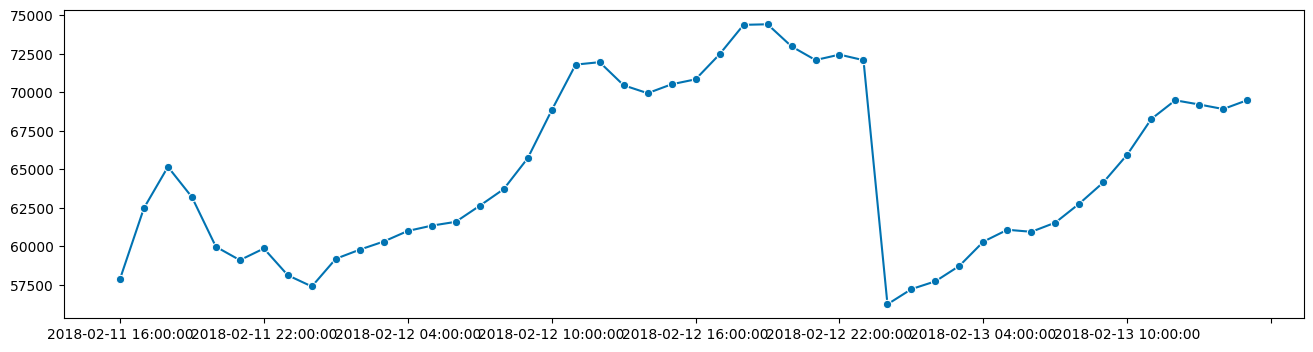

In [113]:
from sktime.transformations.series.date import DateTimeFeatures

# Construct a load forecasting pipeline
load_pipe = ForecastingPipeline(steps=[
    ("standardscaler", TabularToSeriesAdaptor(StandardScaler())),
    ("forecaster", ARIMA((24, 0, 0))),
])

# Construct a price forecasting pipeline
price_pipe = ForecastingPipeline(steps=[
    ("standardscaler", TabularToSeriesAdaptor(StandardScaler())),
    ("forecaster", ARIMA((24, 0, 0))),
])

dt_features_train = DateTimeFeatures(ts_freq="H", manual_selection=["hour_of_day", "day_of_week"]).fit_transform(y_train_load)[["hour_of_day", "day_of_week"]]

# Train all pipelines
load_pipe.fit(y_train_load, dt_features_train)

dt_features_test = DateTimeFeatures(ts_freq="H", manual_selection=["hour_of_day", "day_of_week"]).fit_transform(y_test_load)[["hour_of_day", "day_of_week"]]

predicted_load_train = load_pipe.predict(fh=y_train_load.index, X=dt_features_train)
predicted_load_test = load_pipe.predict(fh=y_test_load.index, X=dt_features_test)
plot_series(predicted_load_test)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

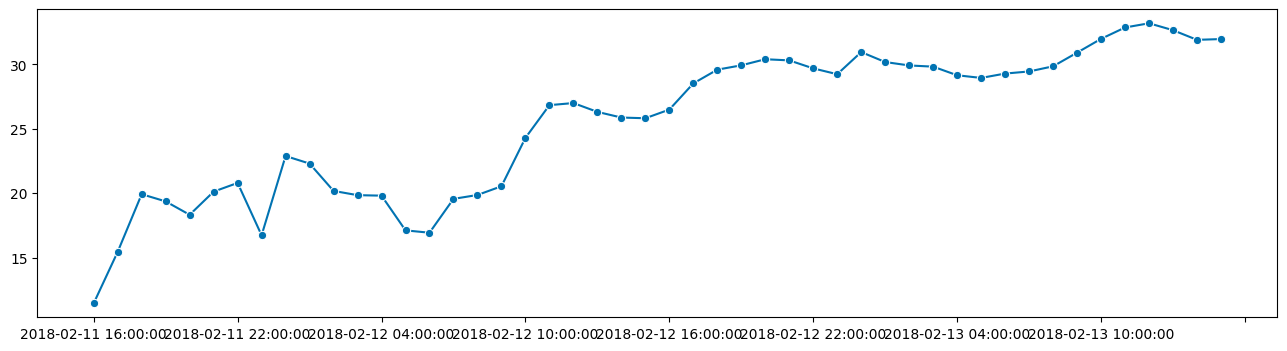

In [110]:
X = dt_features_train

X["load"] = predicted_load_train
price_pipe.fit(y_train, X=X)

# Execute all to predict the future
X = dt_features_test
X["load"] = predicted_load_test
predicted_price = price_pipe.predict(fh=fh, X=X)

plot_series(predicted_price)

## What would be nice improvements`?
* Proposing an end-to-end solution
    * Define one pipeline instead of multiple pipelines
    * Advantages:
        * Only one pipeline needs to be fitted, executed, and managed
        * The whole pipeline can be tuned at once
        * Forecasters can share same preprocessing instances

### Possible Solution: Non-Sequential Pipeline
* Instead of having a single data-flow, a non-sequential pipelines allows the
    * Branching of data flows (calendar features are used by multiple different forecasts)
    * Merging of data flows (output of calendar feature extraction and load forecasting are used by the price forecast)

### Non-Sequential Eletrical Price Forecast Pipeline with Ensembles
<img src="../images/NonSequentialPipelineSimple.png" alt="Non Sequential Pipelien" width="1000"/>


## Need for non-sequential pipelines
* List of further examplary use-cases on [GitHub](https://github.com/sktime/sktime/issues/3023)
    * Wind power generation forecast with hand-crafted feature extraction
    * Theta-Forecaster




## Outlook on Non-Sequential Pipelines
* Concept for realising non-sequential pipelines and prototype exist and are implemented together with pyWATTS ([Main pyWATTS Repo](https://github.com/KIT-IAI/pyWATTS), [Non-Sequential Pipeline Repo](https://github.com/KIT-IAI/pywatts-pipeline))
    * We are developing a sktime API for non-sequential pipelines
        * A design study is performed [here](https://github.com/sktime/sktime/pull/3026#issuecomment-1239648856)
* However, there are still multiple open questions
    * They are collected in this [issue](https://github.com/sktime/sktime/issues/2653)
    * You are invited to work with us on these questions and issues
        * If you have questions concerning the issues, you can contact me via the sktime slack channel.



# Join sktime!

* openly governed, approx equal academia/industry/early career split
    * 19 core developers
    * community council
* numfocus-affiliated, affiliated academic centers in UK (and expanding)

**EVERYONE CAN JOIN! EVERYONE CAN BECOME A COMMUNITY LEADER!**

* join our slack (developers) and discord (events)!
    * regular community collaboration sessions and stand-ups on Fridays
    * multiple Dev Sprints and Dev Days per year
Opportunities:

* job opportunity, maintainer role, watch the jobs channel
* sktime mentoring programme: github.com/sktime/mentoring

## Thank you for your attention

<img src="../images/team.jpg" alt="Sktime Logo" width="1000"/>



# Resources
* The data used here are freely available at the [OPSD Platform](https://open-power-system-data.org/)